<div style="text-align: center;"> <h1> FURIA Know Your Fan (Análise Geral) </h1> </div>

### Configurações Iniciais

#### Importação Chave API (Arquivo .env)

### Coleta de Dados

##### Comentários YTB - JSON (Link)

In [ ]:
import os
import json
from googleapiclient.discovery import build
from dotenv import load_dotenv
from pathlib import Path

env_path = Path('.idea/.env')  # ex: Path('config/.env')
load_dotenv(dotenv_path=env_path)

# Testa se a chave da API está sendo carregada
api_key = os.getenv("YOUTUBE_API_KEY")


# ID do vídeo do qual você quer obter os comentários
video_id = '8aIcU-_5W34'


def get_video_channel_name(video_id, api_key):
    # Conectando à API do YouTube
    youtube = build('youtube', 'v3', developerKey=api_key)
    
    # Obtém as informações do vídeo
    request = youtube.videos().list(
        part='snippet',
        id=video_id
    )
    
    # Realiza a requisição e pega o nome do canal
    response = request.execute()
    if response['items']:
        channel_name = response['items'][0]['snippet']['channelTitle']
        return channel_name
    return None

# Função para obter comentários do vídeo
def get_comments(video_id, api_key):
    # Conectando à API do YouTube
    youtube = build('youtube', 'v3', developerKey=api_key)
    
    # Lista para armazenar os comentários
    comments = []
    
    channel_name = get_video_channel_name(video_id, api_key)
    
    # Inicializa a requisição para obter os comentários
    request = youtube.commentThreads().list(
        part='snippet',
        videoId=video_id,
        textFormat='plainText',
        maxResults=100  # Max resultados por requisição (pode ajustar conforme necessário)
    )
    
    # Realiza a requisição
    while request:
        response = request.execute()
        
        # Itera sobre os comentários e armazena os dados
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            comment_data = {
                    'video_id': video_id,                    # ← aqui você adiciona o ID do vídeo
                    'author': comment['authorDisplayName'],
                    'text': comment['textDisplay'],
                    'published_at': comment['publishedAt'],
                    'likes': comment['likeCount'],
                    'channel_name': channel_name
                }
            
            comments.append(comment_data)
        
        # Verifica se existe uma próxima página de resultados
        request = youtube.commentThreads().list_next(request, response)
    
    return comments

# Obter os comentários
# Função para salvar os comentários sem sobrescrever o arquivo existente
def save_comments(comments, filename='comentarios_video.json'):
    # Caminho da pasta onde você deseja salvar o arquivo
    pasta = 'form_data'

    # Certifique-se de que a pasta existe
    if not os.path.exists(pasta):
        os.makedirs(pasta)

    # Caminho completo do arquivo JSON
    arquivo_json = os.path.join(pasta, filename)
    
    # Verifica se o arquivo já existe
    if os.path.exists(arquivo_json):
        # Carrega o conteúdo existente
        with open(arquivo_json, 'r', encoding='utf-8') as f:
            existing_comments = json.load(f)
        
        # Adiciona os novos comentários ao conteúdo existente
        existing_comments.extend(comments)
        
        # Salva o conteúdo atualizado
        with open(arquivo_json, 'w', encoding='utf-8') as f:
            json.dump(existing_comments, f, indent=4, ensure_ascii=False)
    else:
        # Caso o arquivo não exista, cria um novo com os comentários
        with open(arquivo_json, 'w', encoding='utf-8') as f:
            json.dump(comments, f, indent=4, ensure_ascii=False)

# Obter os comentários
comments = get_comments(video_id, api_key)

# Salvar os comentários sem sobrescrever o arquivo
save_comments(comments)

print("Comentários salvos em 'form_data/comentarios_video.json'")

#### Comentários YTB - JSON - GUI (Custom Tkinter)

In [ ]:
%pip install customtkinter google-api-python-client python-dotenv

In [ ]:
import os
import json
import customtkinter as ctk
from googleapiclient.discovery import build
from dotenv import load_dotenv
from pathlib import Path
import re
import tkinter.messagebox as msgbox

# Load .env
env_path = Path('.idea/.env')  # Ajuste conforme necessário
load_dotenv(dotenv_path=env_path)
api_key = os.getenv("YOUTUBE_API_KEY")

# Detecta ID do vídeo
def extract_video_id(url):
    match = re.search(r"(?:v=|youtu\.be/)([a-zA-Z0-9_-]{11})", url)
    return match.group(1) if match else None

# Detecta ID da playlist
def extract_playlist_id(url):
    match = re.search(r"[?&]list=([a-zA-Z0-9_-]+)", url)
    return match.group(1) if match else None

# Pega nome do canal
def get_video_channel_name(video_id):
    youtube = build('youtube', 'v3', developerKey=api_key)
    request = youtube.videos().list(part='snippet', id=video_id)
    response = request.execute()
    if response['items']:
        return response['items'][0]['snippet']['channelTitle']
    return None

# Busca comentários
def get_comments(video_id):
    youtube = build('youtube', 'v3', developerKey=api_key)
    comments = []
    channel_name = get_video_channel_name(video_id)
    request = youtube.commentThreads().list(
        part='snippet',
        videoId=video_id,
        textFormat='plainText',
        maxResults=100
    )
    while request:
        response = request.execute()
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            comment_data = {
                'video_id': video_id,
                'author': comment['authorDisplayName'],
                'text': comment['textDisplay'],
                'published_at': comment['publishedAt'],
                'likes': comment['likeCount'],
                'channel_name': channel_name
            }
            comments.append(comment_data)
        request = youtube.commentThreads().list_next(request, response)
    return comments

# Salva no JSON
def save_comments(comments, filename='comentarios_video.json'):
    pasta = 'form_data'
    os.makedirs(pasta, exist_ok=True)
    caminho = os.path.join(pasta, filename)
    if os.path.exists(caminho):
        with open(caminho, 'r', encoding='utf-8') as f:
            existentes = json.load(f)
        existentes.extend(comments)
        with open(caminho, 'w', encoding='utf-8') as f:
            json.dump(existentes, f, indent=4, ensure_ascii=False)
    else:
        with open(caminho, 'w', encoding='utf-8') as f:
            json.dump(comments, f, indent=4, ensure_ascii=False)

# Busca vídeos de uma playlist
def get_video_ids_from_playlist(playlist_id):
    youtube = build('youtube', 'v3', developerKey=api_key)
    video_ids = []
    request = youtube.playlistItems().list(
        part='contentDetails',
        playlistId=playlist_id,
        maxResults=50
    )
    while request:
        response = request.execute()
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        request = youtube.playlistItems().list_next(request, response)
    return video_ids

# Processa link inserido
def process_link():
    url = entry_url.get().strip()
    if not url:
        status_label.configure(text="Cole um link válido do YouTube.", text_color="red")
        return

    playlist_id = extract_playlist_id(url)
    video_id = extract_video_id(url)

    if playlist_id:
        try:
            video_ids = get_video_ids_from_playlist(playlist_id)
            total_comments = []
            for vid in video_ids:
                status_label.configure(text=f"Buscando comentários de {vid}...", text_color="blue")
                comments = get_comments(vid)
                total_comments.extend(comments)
            save_comments(total_comments)
            status_label.configure(text=f"Todos os comentários da playlist foram salvos!", text_color="green")
        except Exception as e:
            status_label.configure(text=f"Erro: {e}", text_color="red")
            return

    elif video_id:
        try:
            status_label.configure(text="Buscando comentários do vídeo...", text_color="blue")
            comments = get_comments(video_id)
            save_comments(comments)
            status_label.configure(text=f"Comentários do vídeo foram salvos!", text_color="green")
        except Exception as e:
            status_label.configure(text=f"Erro: {e}", text_color="red")
            return
    else:
        status_label.configure(text="Link inválido. Verifique se é um link do YouTube.", text_color="red")
        return

    # Pergunta se deseja adicionar mais
    continuar = msgbox.askyesno("Continuar", "Deseja adicionar outro vídeo ou playlist?")
    if continuar:
        entry_url.delete(0, 'end')
        status_label.configure(text="Cole outro link para continuar.", text_color="black")
    else:
        app.quit()
        app.destroy()

# GUI com customtkinter
ctk.set_appearance_mode("System")
ctk.set_default_color_theme("blue")

app = ctk.CTk()
app.title("Coletor de Comentários YouTube")
app.geometry("600x300")

label = ctk.CTkLabel(app, text="Cole o link do vídeo ou playlist do YouTube:")
label.pack(pady=10)

entry_url = ctk.CTkEntry(app, width=500)
entry_url.pack(pady=10)

submit_button = ctk.CTkButton(app, text="Buscar e Salvar Comentários", command=process_link)
submit_button.pack(pady=20)

status_label = ctk.CTkLabel(app, text="")
status_label.pack(pady=10)

app.mainloop()


#### Comentários - JSON (Twitter/X)

In [ ]:
import tweepy
import json
import os
from dotenv import load_dotenv
from pathlib import Path

env_path = Path('.idea/.env')  # ex: Path('config/.env')
load_dotenv(dotenv_path=env_path)

chave_api = os.getenv("twitter_api")

# ————————— Configurações e autenticação —————————
BEARER_TOKEN = chave_api  # Substitua pelo seu Bearer Token

client = tweepy.Client(bearer_token=BEARER_TOKEN)

# Parâmetros de pesquisa com a hashtag #DIADEFURIA incluída
query = '(Fallen OR KSCERATO OR yuurih OR molodoy OR skullz OR chelo OR fNb OR Goot OR Envy OR Trigo OR RedBert OR Fntzy OR R4re OR Handyy OR KDS OR yanxnz OR Lostt OR nzr OR Khalil OR havoc OR xand OR mwzera OR Xeratricky OR Pandxrz OR HisWattson OR #FURIACS OR #FURIAR6 OR #FURIAFC OR #DIADEFURIA) -is:retweet lang:pt'
max_results = 10

# Fazendo a busca com os campos desejados
tweets = client.search_recent_tweets(query=query, max_results=max_results,
                                     tweet_fields=["author_id", "conversation_id", "created_at", "geo", "id", "lang", "source", "text"],
                                     user_fields=["created_at", "description", "entities", "id", "location", "name", "url", "username"],
                                     expansions=["author_id"])

# Convertendo os tweets para um formato de dicionário
tweets_data = []
if tweets.data:
    for tweet in tweets.data:
        tweet_info = {
            'tweet_id': tweet.id,
            'text': tweet.text,
            'created_at': str(tweet.created_at),
            'author_id': tweet.author_id,
            'conversation_id': tweet.conversation_id,
            'geo': tweet.geo,
            'lang': tweet.lang,
            'source': tweet.source
        }

        # Obtendo informações do usuário (quem postou o tweet)
        if tweets.includes and 'users' in tweets.includes:
            for user in tweets.includes['users']:
                if user.id == tweet.author_id:
                    tweet_info['user'] = {
                        'created_at': str(user.created_at),
                        'description': user.description,
                        'entities': user.entities,
                        'location': user.location,
                        'name': user.name,
                        'url': user.url,
                        'username': user.username
                    }
                    break

        tweets_data.append(tweet_info)

# Caminho da pasta onde você deseja salvar o arquivo
pasta = 'form_data'

# Certifique-se de que a pasta existe
if not os.path.exists(pasta):
    os.makedirs(pasta)

# Caminho completo do arquivo JSON
arquivo_json = os.path.join(pasta, 'tweetsGerais_furia.json')

# Carrega o conteúdo existente, se houver
if os.path.exists(arquivo_json):
    with open(arquivo_json, 'r', encoding='utf-8') as f:
        dados_existentes = json.load(f)
else:
    dados_existentes = []

# Adiciona os novos tweets
dados_existentes.extend(tweets_data)

# Salva de volta no JSON
with open(arquivo_json, 'w', encoding='utf-8') as f:
    json.dump(dados_existentes, f, ensure_ascii=False, indent=4)

print("Tweets adicionados com sucesso a 'tweets_furia.json'.")

Tweets adicionados com sucesso a 'tweetsGerais_furia.json'.


#### Posts - JSON (Reddit)

In [ ]:
import requests
import json
import os

query = "FURIA OR Fallen OR KSCERATO OR yuurih OR molodoy OR skullz OR chelo OR fNb OR Goot OR Envy OR RedBert OR Fntzy OR R4re OR Handyy OR KDS OR yanxnz OR Lostt OR nzr OR Khalil OR havoc OR xand OR mwzera OR Xeratricky OR Pandxrz OR HisWattson"

subreddits = ["GlobalOffensive", "csgo", "VALORANT", "cs2", "cblol", "LolEsports", "ValorantCompetitive", "VCT", "R6ProLeague"]
limit = 50

resultados = []

# Loop pelos subreddits
for subreddit in subreddits:
    url = f"https://www.reddit.com/r/{subreddit}/search.json?q={query}&restrict_sr=on&limit={limit}"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    response = requests.get(url, headers=headers)
    data = response.json()

    if "data" in data and "children" in data["data"]:
        for post in data["data"]["children"]:
            p = post["data"]

            # Verifica se a query aparece no título ou no texto do post
            titulo = p.get("title", "")
            texto = p.get("selftext", "")

            # Verificação literal, sem usar lower()
            if any(jogador in titulo or jogador in texto for jogador in query.split(" OR ")):
                resultados.append({
                    "titulo": p.get("title"),
                    "autor": p.get("author"),
                    "subreddit": subreddit,
                    "score": p.get("score", 0),
                    "url": "https://reddit.com" + p.get("permalink"),
                    "data_criacao": p.get("created_utc"),
                    "comentario_exemplo": p.get("selftext", "")
                })

# Caminho da pasta onde você deseja salvar o arquivo
pasta = 'form_data'

# Certifique-se de que a pasta existe
if not os.path.exists(pasta):
    os.makedirs(pasta)

# Caminho completo do arquivo JSON
arquivo_json = os.path.join(pasta, "posts_furia_reddit.json")

# Salva em JSON
# Verifica se o arquivo já existe e carrega os dados antigos
if os.path.exists(arquivo_json):
    with open(arquivo_json, "r", encoding="utf-8") as f:
        dados_existentes = json.load(f)
else:
    dados_existentes = []

# Junta os dados antigos com os novos
dados_atuaisizados = dados_existentes + resultados

# Salva todos os dados no JSON
with open(arquivo_json, "w", encoding="utf-8") as f:
    json.dump(dados_atuaisizados, f, indent=4, ensure_ascii=False)
    print("Novos dados adicionados ao JSON.")



<div style="text-align: center;"> <h3>Enriquecimento de Perfil com Dados Sociais e Multimídia</h3> </div>

- **Análise de Comentários:** Para integrar comentários prévios do usuário no YouTube, Reddit e Twitter, incluir blocos que consumam APIs ou dados locais de análise anterior (supondo que existam). Usar `google-api-python-client` para extrair comentários de vídeos de e-sports do YouTube, `PRAW` para posts/comentários no Reddit, e `tweepy` ou dados simulados para tweets.  
- **Processamento de Linguagem Natural:** Aplicar NLP para entender o perfil do usuário: usar bibliotecas como `transformers` ou `spaCy` para classificar sentimento, identificar tópicos ou palavras-chave frequentes nesses comentários. Por exemplo, gerar um gráfico de palavras-chave mais mencionadas em e-sports, ou uma análise de sentimento geral sobre jogos específicos.  
- **Integração de Informações:** Combinar esses insights com os interesses declarados pelo usuário. Exibir visualmente (via `matplotlib` ou `seaborn`) uma nuvem de palavras ou gráfico que mostre as categorias de e-sports mais relevantes para o perfil (baseado em interesses + análise de comentários).  
- **Perfis em Sites de e-Sports:** Permitir que o usuário insira links para seus perfis em plataformas de e-sports (como GameBattles, HLTV, Liquipedia). Usar `requests` e `BeautifulSoup` para raspar detalhes do perfil (jogos, histórico de partidas). Em seguida, aplicar um modelo de IA (ex: `transformers` BERT) para classificar se o conteúdo textual do perfil é relevante às preferências do usuário (por exemplo, buscando termos de jogos citados pelo usuário). Mostrar se há “match” entre interesses do usuário e informações do perfil scraped.  

### Análise de Dados

#### Análise Geral (Youtube)

In [ ]:
%pip install pandas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_json(R'form_data\comentarios_video.json')

Remoção de Duplicatas

In [ ]:
df_unico = df.drop_duplicates(subset=["text", "author"])

# Salva o DataFrame limpo de volta no JSON
df_unico.to_json(R"form_data\comentarios_video.json", orient="records", indent=4, force_ascii=False)

print(f"Removidas {len(df) - len(df_unico)} duplicatas.")

In [ ]:
# 2. Converte published_at (ISO 8601) para datetime do pandas
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)

# 3. Extrai colunas de data e hora para facilitar agregações
df['data'] = df['published_at'].dt.date
df['hora'] = df['published_at'].dt.time

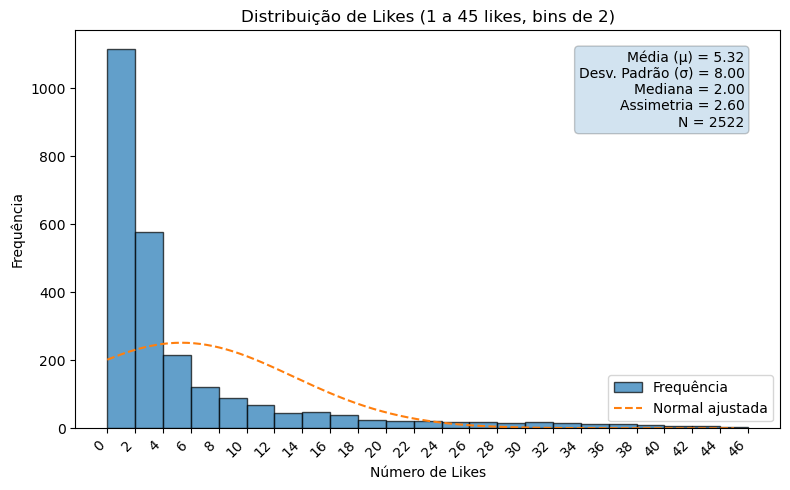

5449 comentários removidos (0 ou >45 likes)
Estatísticas dos comentários mantidos:
Média (μ) = 5.32
Desv. Padrão (σ) = 8.00
Mediana = 2.00
Assimetria = 2.60
N = 2522


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. Carrega o JSON em DataFrame
df = pd.read_json('form_data/comentarios_video.json')

# 2. Separa comentários válidos (1 a 45 likes) e calcula estatísticas
df_filtrado = df[(df['likes'] > 0) & (df['likes'] <= 45)]
# Extrai série de likes após filtragem
n_likes = df_filtrado['likes']
# Estatísticas descritivas
mu = n_likes.mean()
sigma = n_likes.std(ddof=0)
median = n_likes.median()
skewness = n_likes.skew()

# 3. Configura histograma e sobrepõe curva Normal ajustada
bin_edges = np.arange(0, 47, 2)
bin_width = bin_edges[1] - bin_edges[0]
counts, bins = np.histogram(n_likes, bins=bin_edges)

plt.figure(figsize=(8, 5))
# histograma
plt.hist(n_likes, bins=bin_edges, edgecolor='black', alpha=0.7, label='Frequência')
# curva Normal ajustada (densidade * escala)
x = np.linspace(0, 45, 500)
pdf = norm.pdf(x, mu, sigma) * len(n_likes) * bin_width
plt.plot(x, pdf, linestyle='--', label='Normal ajustada')

# 4. Anotações de estatísticas
stats_text = (
    f'Média (μ) = {mu:.2f}\n'
    f'Desv. Padrão (σ) = {sigma:.2f}\n'
    f'Mediana = {median:.2f}\n'
    f'Assimetria = {skewness:.2f}\n'
    f'N = {len(n_likes)}'
)
plt.gca().text(
    0.95, 0.95, stats_text,
    transform=plt.gca().transAxes,
    verticalalignment='top', horizontalalignment='right',
    fontsize='10', bbox=dict(boxstyle='round', alpha=0.2)
)

# 5. Ajustes visuais
ticks = bin_edges
labels = [str(int(b)) for b in bin_edges]
plt.xticks(ticks=ticks, labels=labels, rotation=45, ha='right')
plt.title('Distribuição de Likes (1 a 45 likes, bins de 2)')
plt.xlabel('Número de Likes')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

# 6. Exibe resumo de removidos e estatísticas
removed = df.shape[0] - df_filtrado.shape[0]
print(f"{removed} comentários removidos (0 ou >45 likes)")
print(f"Estatísticas dos comentários mantidos:\n{stats_text}")


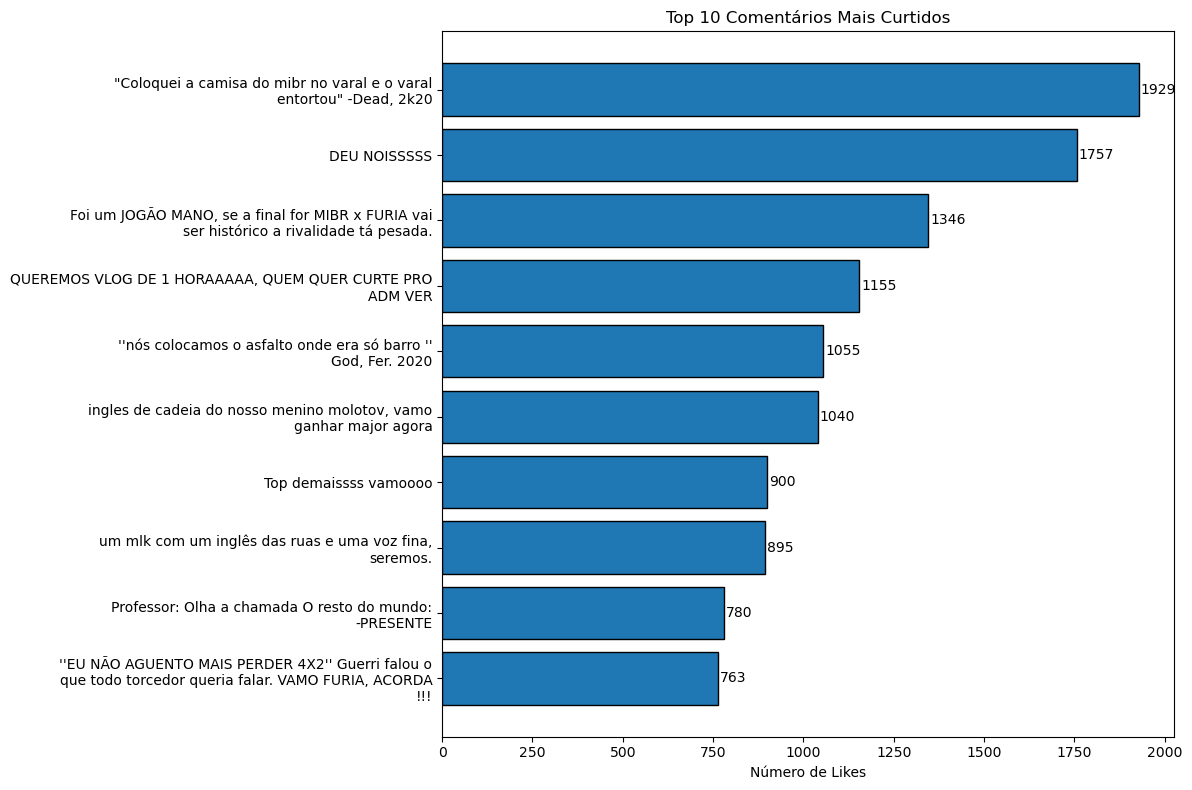

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# 1. Carrega o JSON em DataFrame
df = pd.read_json('form_data/comentarios_video.json')

# 2. Ordena pelo número de likes e pega os top N (ajuste N se quiser mais/menos)
N = 10
top_comments = df.sort_values('likes', ascending=False).head(N)

# 3. Prepara os rótulos: quebra linhas para caber melhor no gráfico
wrapped_texts = [
    textwrap.fill(text, width=50)
    for text in top_comments['text']
]

# 4. Plota gráfico de barras horizontais com o texto do comentário
plt.figure(figsize=(12, 8))
plt.barh(range(N), top_comments['likes'], edgecolor='black')
plt.yticks(range(N), wrapped_texts)
plt.xlabel('Número de Likes')
plt.title(f'Top {N} Comentários Mais Curtidos')
plt.gca().invert_yaxis()  # Inverte o eixo para o comentário mais curtido ficar no topo

# 5. Anotações com o número exato de likes ao final de cada barra
for i, like in enumerate(top_comments['likes']):
    plt.text(like + 5, i, str(like), va='center')

plt.tight_layout()
plt.show()


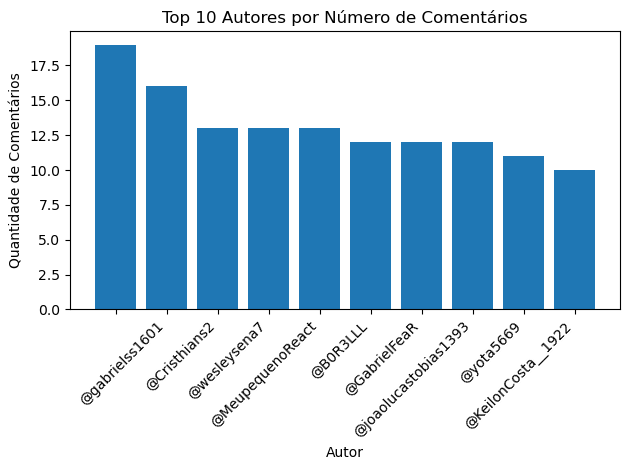

In [6]:
# Top 10 autores por número de comentários
top_autores = df['author'].value_counts().head(10)
plt.figure()
plt.bar(top_autores.index, top_autores.values)
plt.title('Top 10 Autores por Número de Comentários')
plt.xlabel('Autor')
plt.ylabel('Quantidade de Comentários')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

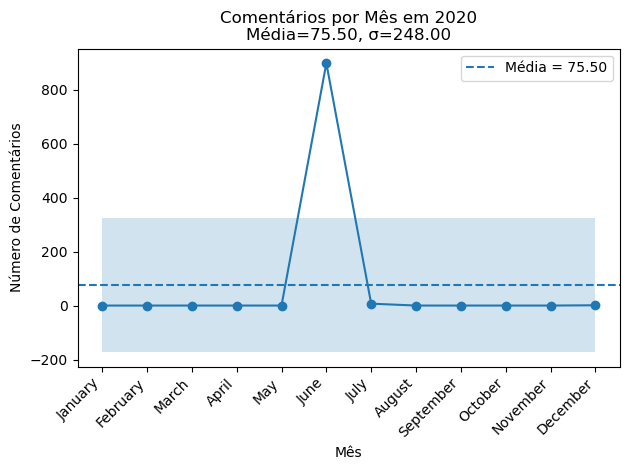

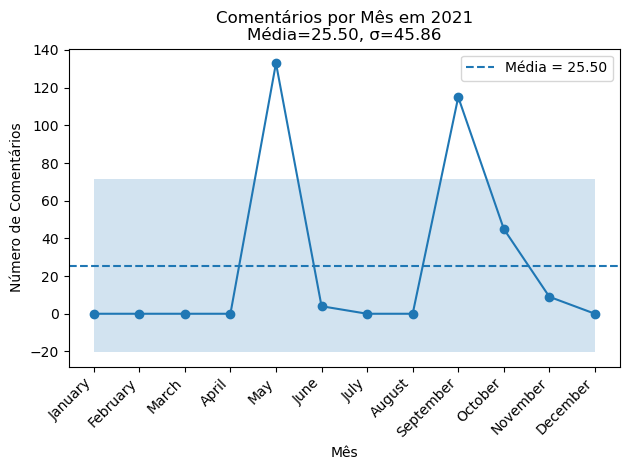

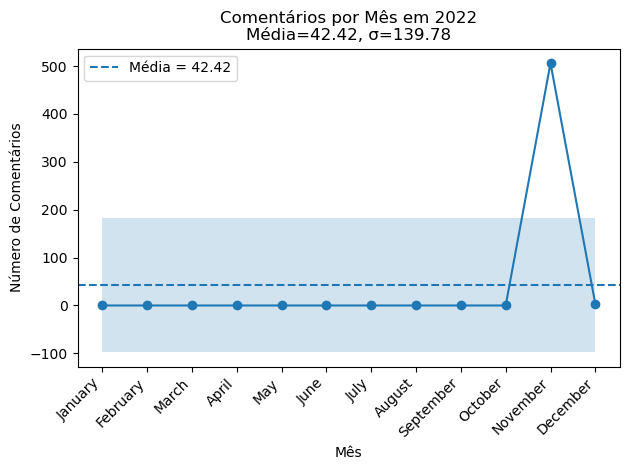

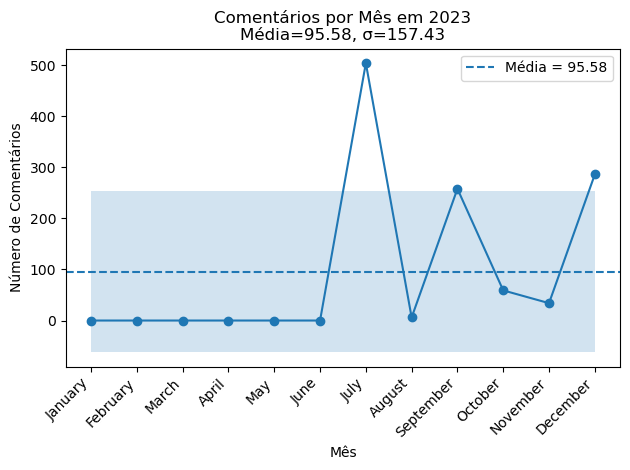

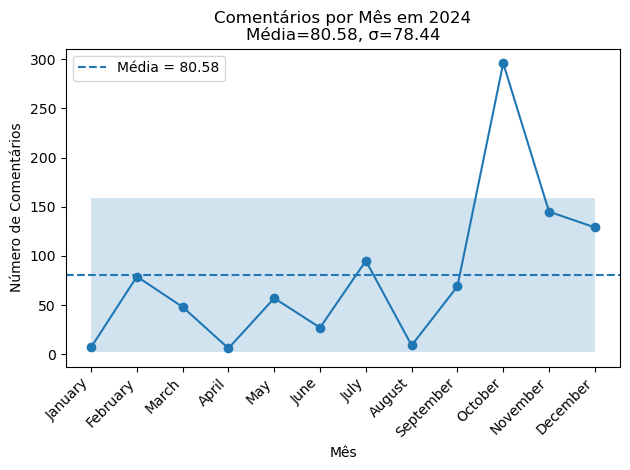

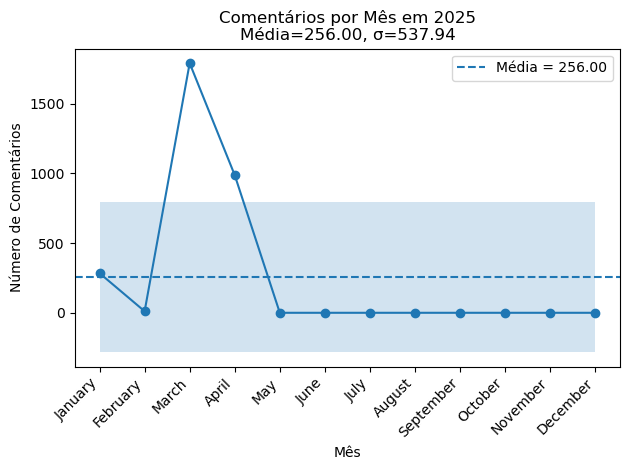

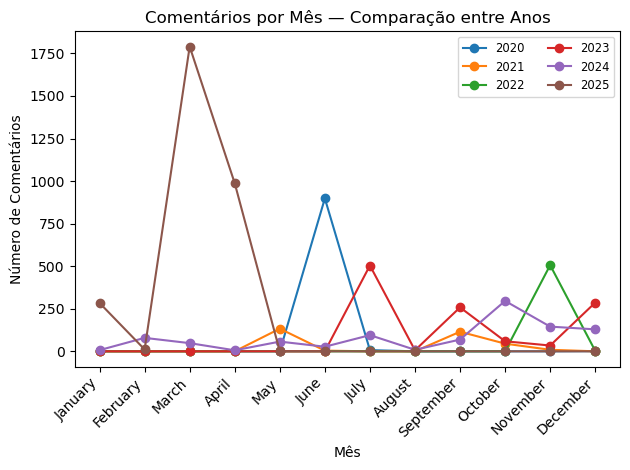

In [44]:
import calendar
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. Converte published_at para datetime e extrai ano e mês
# 2. Filtra para ignorar anos antes de 2000
# (pressupondo df já carregado com coluna 'published_at')
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)
df['year'] = df['published_at'].dt.year
df['month'] = df['published_at'].dt.month
df = df[df['year'] >= 2000]

# 3. Para cada ano: série temporal + estatísticas + sombra de ±1σ
for year in sorted(df['year'].unique()):
    df_year = df[df['year'] == year]
    comentarios_por_mes = (
        df_year.groupby('month')
               .size()
               .reindex(range(1,13), fill_value=0)
    )
    # estatísticas
    valores = comentarios_por_mes.values
    mu = valores.mean()
    sigma = valores.std(ddof=0)

    plt.figure()
    # série temporal
    plt.plot(comentarios_por_mes.index, valores, marker='o')
    # linha da média
    plt.axhline(mu, linestyle='--', label=f'Média = {mu:.2f}')
    # banda de ±1σ
    plt.fill_between(
        comentarios_por_mes.index,
        mu - sigma,
        mu + sigma,
        alpha=0.2
    )

    plt.title(f'Comentários por Mês em {year}\nMédia={mu:.2f}, σ={sigma:.2f}')
    plt.xlabel('Mês')
    plt.ylabel('Número de Comentários')
    labels = [calendar.month_name[m] for m in comentarios_por_mes.index]
    plt.xticks(ticks=comentarios_por_mes.index, labels=labels, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 4. Gráfico combinado: todas as séries anuais no mesmo eixo
# prepara pivot: linhas=year, colunas=month
table = (
    df.groupby(['year', 'month'])
      .size()
      .unstack(fill_value=0)
      .reindex(columns=range(1,13), fill_value=0)
)

plt.figure()
for year, row in table.iterrows():
    plt.plot(row.index, row.values, marker='o', label=str(year))

plt.title('Comentários por Mês — Comparação entre Anos')
plt.xlabel('Mês')
plt.ylabel('Número de Comentários')
plt.xticks(ticks=range(1,13), labels=[calendar.month_name[m] for m in range(1,13)], rotation=45, ha='right')
plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()


Device set to use cpu


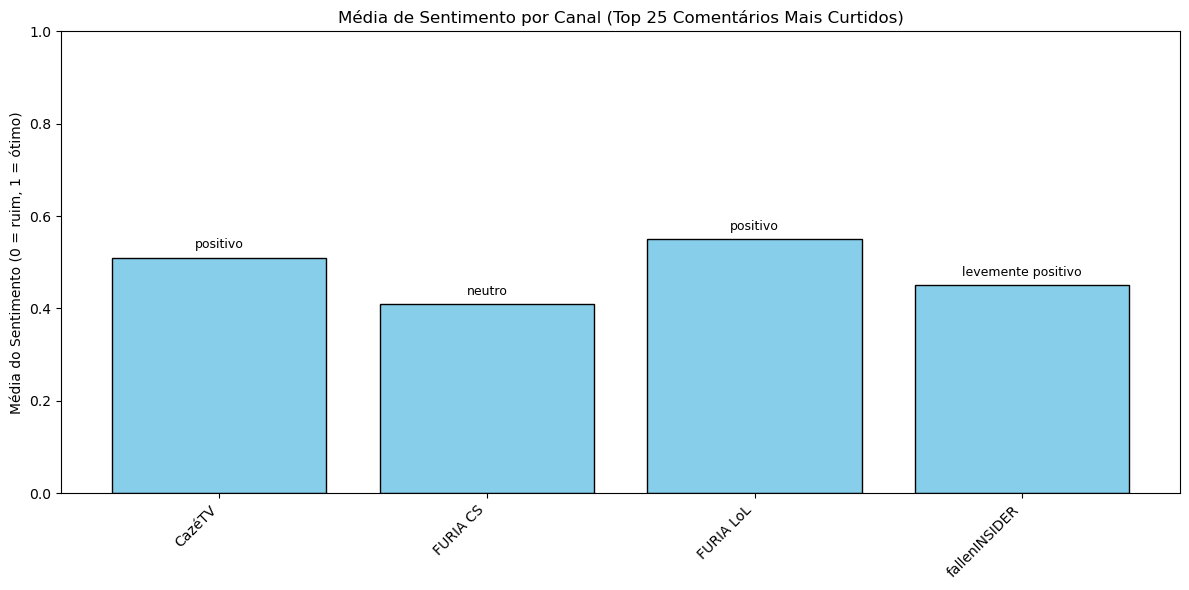

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline

# 1. Caminho do JSON
JSON_PATH = 'form_data/comentarios_video.json'

# 2. Carrega o DataFrame
df = pd.read_json(JSON_PATH)

# 3. Top 10 comentários mais curtidos por canal
top_por_canal = (
    df
    .sort_values(['channel_name', 'likes'], ascending=[True, False])
    .groupby('channel_name')
    .head(25)
)

# 4. Pipeline de sentimento
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    tokenizer="nlptown/bert-base-multilingual-uncased-sentiment",
    device=-1
)

# 5. Aplica o modelo em lotes
def analyze_batch(texts):
    return sentiment_analyzer(texts, truncation=True)

results = []
batch_size = 32
texts = top_por_canal['text'].tolist()
for i in range(0, len(texts), batch_size):
    results.extend(analyze_batch(texts[i:i+batch_size]))

# 6. Processa os resultados
scores, labels = [], []
for res in results:
    stars = int(res['label'][0])
    score = (stars - 1) / 4
    if stars == 1:
        sentiment = "muito negativo"
    elif stars == 2:
        sentiment = "negativo"
    elif stars == 3:
        sentiment = "neutro"
    elif stars == 4:
        sentiment = "positivo"
    else:
        sentiment = "muito positivo"
    scores.append(score)
    labels.append(sentiment)

top_por_canal = top_por_canal.reset_index(drop=True)
top_por_canal['sentiment_score'] = scores
top_por_canal['sentiment'] = labels

# 7. Classificação por faixa de média
def classificar_media(score):
    if score <= 0.2:
        return "muito negativo"
    elif score <= 0.3:
        return "negativo"
    elif score <= 0.43:
        return "neutro"
    elif score <= 0.5:
        return "levemente positivo"
    elif score <= 0.65:
        return "positivo"
    elif score <= 0.8:
        return "muito positivo"
    else:
        return "extremamente positivo"

# 8. Agrupamento por canal com contagem
resumo_canais = (
    top_por_canal
    .groupby('channel_name')
    .agg(
        mean_sentiment_score=('sentiment_score', 'mean'),
        total_comentarios=('sentiment_score', 'count')
    )
    .reset_index()
)

# 9. Aplica rótulo textual e monta nome com contagem
resumo_canais['sentiment_class'] = resumo_canais['mean_sentiment_score'].apply(classificar_media)
resumo_canais['channel_label'] = resumo_canais.apply(
    lambda row: f"{row['channel_name']}", axis=1
)

# 10. Gráfico
plt.figure(figsize=(12, 6))
bars = plt.bar(resumo_canais['channel_label'], resumo_canais['mean_sentiment_score'], color='skyblue', edgecolor='black')
plt.ylabel('Média do Sentimento (0 = ruim, 1 = ótimo)')
plt.ylim(0, 1)
plt.title('Média de Sentimento por Canal (Top 25 Comentários Mais Curtidos)')
plt.xticks(rotation=45, ha='right')

# 11. Anota a classificação acima das barras
for bar, label in zip(bars, resumo_canais['sentiment_class']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, label, ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
import textwrap

# Lista de palavras banidas
palavras_banidas = ['CAPIM', 'Desempedidos', 'G3X', 'g3x', 'DENDELE', 'LOUD', 'FUNKBOL', 'FLUXO REAL ELITE']

# 1. Filtra os 200 melhores comentários por likes
top100 = df.sort_values('likes', ascending=False).head(200).copy()

# 2. Filtra comentários que contenham palavras banidas
top100_filtrado = top100[~top100['text'].str.upper().str.contains('|'.join(palavras_banidas))]

# 3. Cria o pipeline de análise de sentimento
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    tokenizer="nlptown/bert-base-multilingual-uncased-sentiment",
    device=-1  # CPU
)

# 4. Aplica em lotes a análise de sentimentos
results = []
batch_size = 32
texts = top100_filtrado['text'].tolist()
for i in range(0, len(texts), batch_size):
    results.extend(sentiment_analyzer(texts[i:i+batch_size], truncation=True))

# 5. Converte labels em score normalizado
scores = []
for res in results:
    stars = int(res['label'][0])
    score = (stars - 1) / 4  # normaliza para 0–1
    scores.append(score)

top100_filtrado = top100_filtrado.reset_index(drop=True)
top100_filtrado['sentiment_score'] = scores

# 6. Filtra 10 comentários por canal com base no score de sentimento
top_comentarios_canal = []

for channel, group in top100_filtrado.groupby('channel_name'):
    top_comentarios_canal.append(group.sort_values('sentiment_score', ascending=False).head(10))

top_comentarios_canal = pd.concat(top_comentarios_canal).reset_index(drop=True)

# Função para simplificar comentários longos
def simplificar_comentario(texto, limite=250):
    if len(texto) <= limite:
        return texto
    palavras = texto.split()
    return f"{texto[:limite].rstrip()}... {' '.join(palavras[-2:])}"

# 7. Função para plotar gráfico individual para cada canal, agora exibindo o número de likes
def plot_comentarios_canal(df, canal):
    comentarios = [textwrap.fill(simplificar_comentario(txt), width=50) for txt in df['text']]
    likes = df['likes']
    
    spacing = 1.5  # aumenta a distância entre as barras
    y_positions = [i * spacing for i in range(len(comentarios))]

    plt.figure(figsize=(10, len(df) * 1.5))
    bars = plt.barh(y_positions, likes, color='green')
    plt.yticks(y_positions, comentarios)
    plt.xlabel('Número de Likes')
    plt.title(f'Top 10 Comentários Mais Curtidos - Canal: {canal}')
    plt.gca().invert_yaxis()

    # Exibe o número de likes ao lado de cada barra
    for y, like in zip(y_positions, likes):
        plt.text(like + 0.5, y, f'{like}', va='center')

    plt.tight_layout()
    plt.show()

# 8. Cria um gráfico para cada canal
for channel, group in top_comentarios_canal.groupby('channel_name'):
    plot_comentarios_canal(group, channel)


##### Análise de Sentimento

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
import textwrap
import json
import random

# ====== 1. Carrega os dados JSON ======
with open(r'form_data/tweets_User.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# ====== 2. Elimina duplicatas baseado no texto ======
df = df.drop_duplicates(subset=['text'])

# ====== 3. Adiciona likes aleatórios para simulação ======
df['likes'] = [random.randint(1, 5000) for _ in range(len(df))]

# ====== 4. Filtra os 200 melhores por likes ======
top200 = df.sort_values('likes', ascending=False).head(200).copy()

# ====== 5. Remove palavras banidas ======
palavras_banidas = ['CAPIM', 'Desempedidos', 'G3X', 'g3x', 'DENDELE', 'LOUD', 'FUNKBOL', 'FLUXO REAL ELITE']
top200_filtrado = top200[~top200['text'].str.upper().str.contains('|'.join(palavras_banidas))]

# ====== 6. Cria pipeline de análise de sentimento ======
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    tokenizer="nlptown/bert-base-multilingual-uncased-sentiment"
)

# ====== 7. Aplica o modelo de análise de sentimento ======
batch_size = 32
top200_filtrado = top200_filtrado.reset_index(drop=True)
texts = top200_filtrado['text'].tolist()
results = []
for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    results.extend(sentiment_analyzer(batch, truncation=True))

# ====== 8. Normaliza os scores de sentimento ======
scores = [(int(res['label'][0]) - 1) / 4 for res in results]
top200_filtrado['sentiment_score'] = scores

# ====== 9. Adiciona um campo "channel_name" ======
top200_filtrado['channel_name'] = top200_filtrado['author'].apply(lambda a: a['username'])

# ====== 10. Pega os top 10 comentários por canal ======
top_comentarios_canal = []
for canal, grupo in top200_filtrado.groupby('channel_name'):
    top_comentarios_canal.append(grupo.sort_values('sentiment_score', ascending=False).head(10))
top_comentarios_canal = pd.concat(top_comentarios_canal).reset_index(drop=True)

# ====== 11. Funções auxiliares ======
def simplificar_comentario(texto, limite=250):
    if len(texto) <= limite:
        return texto
    palavras = texto.split()
    return f"{texto[:limite].rstrip()}... {' '.join(palavras[-2:])}"


def estrela_para_sentimento(score):
    """
    Converte score normalizado (0-1) para sentimento textual em 1-5 estrelas.
    """
    stars = int(round(score * 4)) + 1
    if stars == 1:
        return "muito negativo"
    elif stars == 2:
        return "negativo"
    elif stars == 3:
        return "neutro"
    elif stars == 4:
        return "positivo"
    else:
        return "muito positivo"

# ====== 12. Função para gerar gráfico com sentimento ======
def plot_comentarios_canal(df, canal):
    comentarios = [textwrap.fill(simplificar_comentario(txt), width=50) for txt in df['text']]
    sentiment_scores = df['sentiment_score']
    
    spacing = 1.5
    y_positions = [i * spacing for i in range(len(comentarios))]

    plt.figure(figsize=(12, len(df) * 1.5))
    plt.barh(y_positions, sentiment_scores, color='skyblue')  # azul claro
    plt.yticks(y_positions, comentarios)
    plt.xlabel('Score de Sentimento (0 - Negativo, 1 - Positivo)')
    plt.title(f'Comentários e Sentimento - @{canal}')
    plt.gca().invert_yaxis()

    # Exibe o score de sentimento e texto do sentimento ao lado de cada barra
    for y, score in zip(y_positions, sentiment_scores):
        sentimento = estrela_para_sentimento(score)
        plt.text(score + 0.01, y, f'{score:.2f} ({sentimento})', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# ====== 13. Gera o gráfico para cada canal ======
for canal, grupo in top_comentarios_canal.groupby('channel_name'):
    plot_comentarios_canal(grupo, canal)


#### Análise Geral Reddit

Device set to use cpu


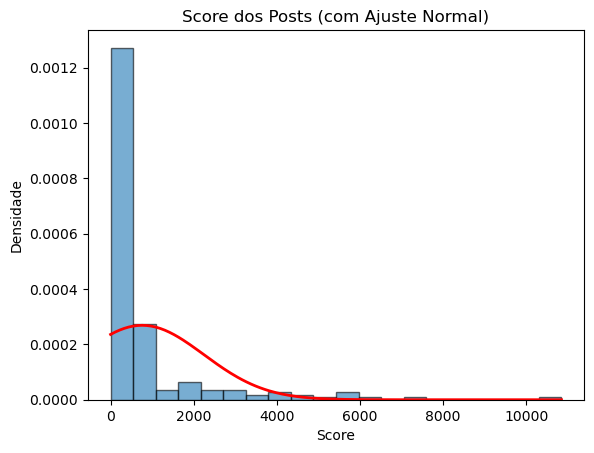

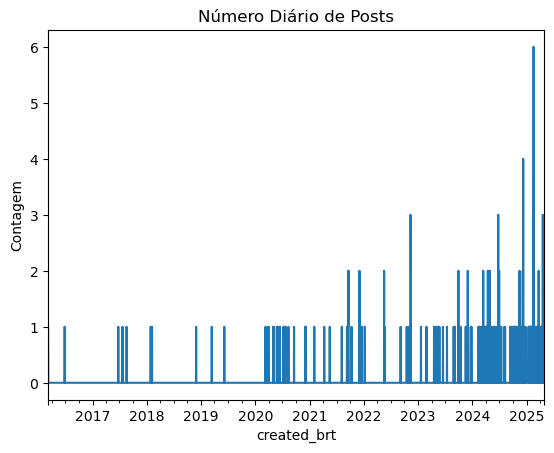

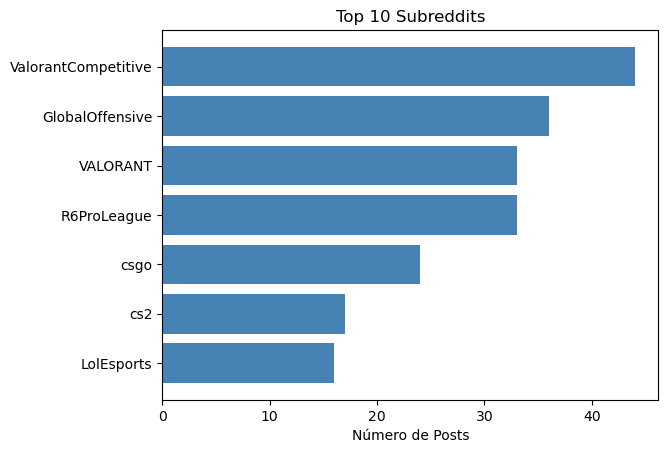

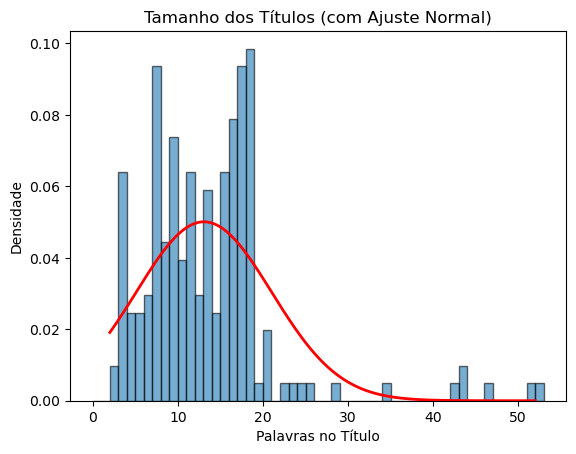

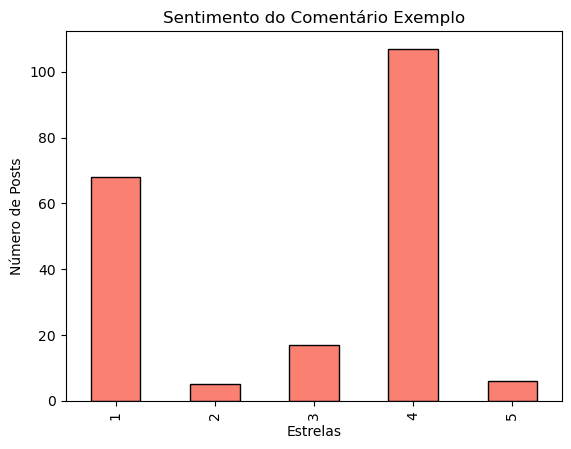

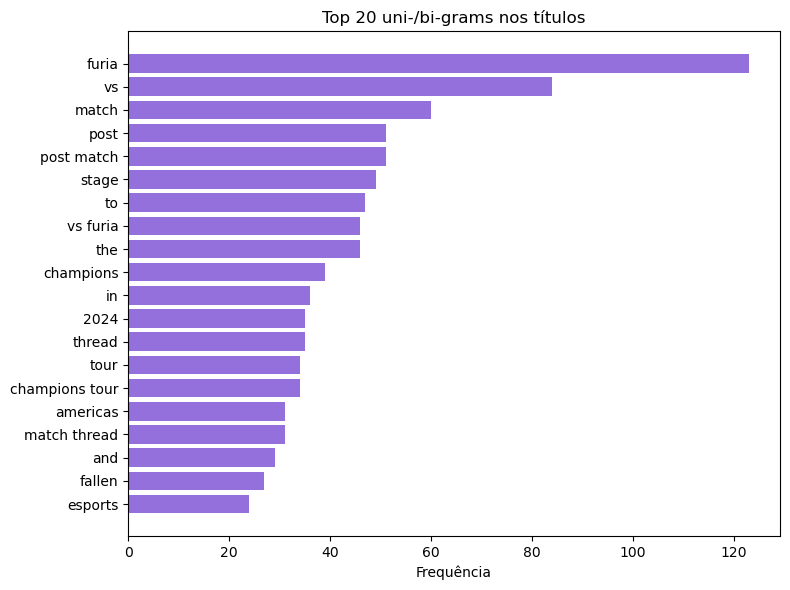

Device set to use cpu
c:\Users\leomo\miniconda3\Lib\site-packages\transformers\pipelines\token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


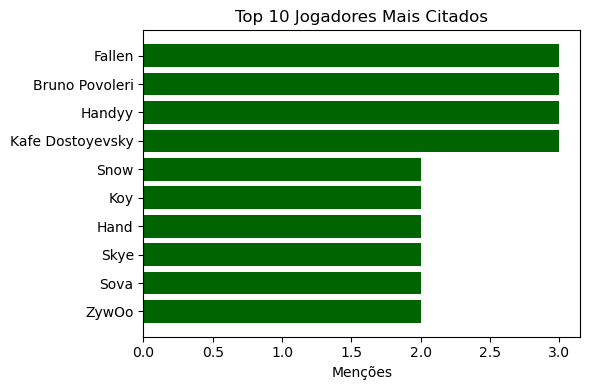

In [41]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# ====== 0. Parâmetro: caminho para o JSON ======
JSON_PATH = 'form_data/posts_furia_reddit.json'  # <- ajuste conforme seu arquivo

# ====== 1. Carregamento ======
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Arquivo não encontrado: {path}")
    with open(path, 'r', encoding='utf-8') as f:
        return pd.DataFrame(json.load(f))

# ====== 2. Limpeza ======
def clean_data(df):
    df = df.drop_duplicates(subset=['url'])
    df = df.dropna(subset=['titulo', 'comentario_exemplo']).reset_index(drop=True)
    return df

# ====== 3. Featurização ======
def engineer_features(df):
    df['created_utc'] = pd.to_datetime(df['data_criacao'], unit='s', utc=True)
    df['created_brt'] = df['created_utc'].dt.tz_convert('America/Sao_Paulo')
    df['titulo_len_chars'] = df['titulo'].str.len()
    df['titulo_len_words'] = df['titulo'].str.split().apply(len)
    df['weekday'] = df['created_brt'].dt.day_name(locale='pt_BR')
    df['hour']    = df['created_brt'].dt.hour
    return df

# ====== 4. Análise de Sentimento ======
def analyze_sentiment(df):
    nltk.download('stopwords', quiet=True)
    pt_stop = stopwords.words('portuguese')
    sentiment_analyzer = pipeline(
        "sentiment-analysis",
        model="nlptown/bert-base-multilingual-uncased-sentiment",
        tokenizer="nlptown/bert-base-multilingual-uncased-sentiment"
    )
    df['sentiment_score'] = df['comentario_exemplo'].apply(
        lambda t: int(sentiment_analyzer(t[:512], truncation=True)[0]['label'][0])
    )
    return df, pt_stop

# ====== 5. Extração de jogadores via NER ======
def extract_player_mentions(df):
    # modelo multilíngue NER rodando em "grouped_entities"
    ner = pipeline(
        "ner",
        model="Davlan/bert-base-multilingual-cased-ner-hrl",
        tokenizer="Davlan/bert-base-multilingual-cased-ner-hrl",
        grouped_entities=True
    )
    texts = pd.concat([df['titulo'], df['comentario_exemplo']]).unique()
    mentions = []
    for txt in texts:
        entities = ner(txt[:512])
        # coletar apenas entidades de tipo PESSOA
        mentions += [e['word'] for e in entities if e['entity_group'] == 'PER']
    return Counter(mentions)

# ====== 6. Plots Estatísticos ======
def plot_score_distribution(df):
    scores = df['score']
    μ, σ = scores.mean(), scores.std(ddof=0)
    plt.figure()
    plt.hist(scores, bins=20, density=True, alpha=0.6, edgecolor='black')
    x = np.linspace(scores.min(), scores.max(), 200)
    pdf = (1/(σ*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-μ)/σ)**2)
    plt.plot(x, pdf, 'r-', lw=2)
    plt.title('Score dos Posts (com Ajuste Normal)')
    plt.xlabel('Score')
    plt.ylabel('Densidade')
    plt.show()

def plot_time_series(df):
    serie = df.set_index('created_brt').resample('D').size()
    plt.figure()
    serie.plot()
    plt.title('Número Diário de Posts')
    plt.ylabel('Contagem')
    plt.show()

def plot_top_subreddits(df):
    top = df['subreddit'].value_counts().head(10)
    plt.figure()
    plt.barh(top.index[::-1], top.values[::-1], color='steelblue')
    plt.title('Top 10 Subreddits')
    plt.xlabel('Número de Posts')
    plt.show()

def plot_title_length_distribution(df):
    lengths = df['titulo_len_words']
    μ, σ = lengths.mean(), lengths.std(ddof=0)
    plt.figure()
    plt.hist(lengths, bins=range(0, int(lengths.max())+2), density=True, alpha=0.6, edgecolor='black')
    x = np.linspace(lengths.min(), lengths.max(), 200)
    pdf = (1/(σ*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-μ)/σ)**2)
    plt.plot(x, pdf, 'r-', lw=2)
    plt.title('Tamanho dos Títulos (com Ajuste Normal)')
    plt.xlabel('Palavras no Título')
    plt.ylabel('Densidade')
    plt.show()

def plot_sentiment_distribution(df):
    counts = df['sentiment_score'].value_counts().sort_index()
    plt.figure()
    counts.plot(kind='bar', color='salmon', edgecolor='black')
    plt.title('Sentimento do Comentário Exemplo')
    plt.xlabel('Estrelas')
    plt.ylabel('Número de Posts')
    plt.show()

def plot_ngrams(df, stop_words, top_n=20):
    vec = CountVectorizer(ngram_range=(1,2), stop_words=stop_words)
    X = vec.fit_transform(df['titulo'])
    sums = X.sum(axis=0)
    terms = [(t, sums[0, idx]) for t, idx in vec.vocabulary_.items()]
    top_terms = sorted(terms, key=lambda x: x[1], reverse=True)[:top_n]
    labels, freqs = zip(*top_terms)
    plt.figure(figsize=(8,6))
    plt.barh(labels[::-1], freqs[::-1], color='mediumpurple')
    plt.title(f'Top {top_n} uni-/bi-grams nos títulos')
    plt.xlabel('Frequência')
    plt.tight_layout()
    plt.show()

def plot_player_mentions(counter, top_n=10):
    most = counter.most_common(top_n)
    players, freqs = zip(*most)
    plt.figure(figsize=(6,4))
    plt.barh(players[::-1], freqs[::-1], color='darkgreen')
    plt.title(f'Top {top_n} Jogadores Mais Citados')
    plt.xlabel('Menções')
    plt.tight_layout()
    plt.show()

# ====== 7. Main ======
def main():
    df = load_data(JSON_PATH)
    df = clean_data(df)
    df = engineer_features(df)
    df, pt_stop = analyze_sentiment(df)

    plot_score_distribution(df)
    plot_time_series(df)
    plot_top_subreddits(df)
    plot_title_length_distribution(df)
    plot_sentiment_distribution(df)
    plot_ngrams(df, pt_stop, top_n=20)

    # extrai e plota jogadores
    counter_players = extract_player_mentions(df)
    plot_player_mentions(counter_players, top_n=10)

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import calendar

# 1. Carrega o JSON de posts do Reddit
posts = pd.read_json('form_data/posts_furia_reddit.json')

# 2. Converte timestamp UNIX para datetime e extrai ano/mês
posts['data_criacao'] = pd.to_datetime(posts['data_criacao'], unit='s', utc=True)
posts['year'] = posts['data_criacao'].dt.year
posts['month'] = posts['data_criacao'].dt.month

# 3. Filtra anos relevantes (>= 2000)
posts = posts[posts['year'] >= 2000]

# 4. Para cada ano: posts por mês + estatísticas + banda ±1σ
for year in sorted(posts['year'].unique()):
    df_year = posts[posts['year'] == year]
    counts = df_year.groupby('month').size().reindex(range(1,13), fill_value=0)
    vals = counts.values
    mu, sigma = vals.mean(), vals.std(ddof=0)

    plt.figure()
    plt.plot(counts.index, vals, marker='o')
    plt.axhline(mu, linestyle='--', label=f'Média = {mu:.2f}')
    plt.fill_between(counts.index, mu - sigma, mu + sigma, alpha=0.2)

    plt.title(f'Posts por Mês em {year}\nMédia={mu:.2f}, σ={sigma:.2f}')
    plt.xlabel('Mês')
    plt.ylabel('Número de Posts')
    plt.xticks(ticks=counts.index, labels=[calendar.month_name[m] for m in counts.index], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 5. Gráfico combinado: todos os anos
pivot = posts.groupby(['year','month']).size().unstack(fill_value=0).reindex(columns=range(1,13), fill_value=0)
plt.figure()
for year, row in pivot.iterrows():
    plt.plot(row.index, row.values, marker='o', label=str(year))

plt.title('Posts por Mês — Comparação entre Anos')
plt.xlabel('Mês')
plt.ylabel('Número de Posts')
plt.xticks(ticks=range(1,13), labels=[calendar.month_name[m] for m in range(1,13)], rotation=45, ha='right')
plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()


#### Análise Geral Twitter

##### Análise de Sentimento

Device set to use cpu
C:\Users\leomo\AppData\Local\Temp\ipykernel_3104\3585942766.py:92: UserWarning: Glyph 128062 (\N{PAW PRINTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leomo\AppData\Local\Temp\ipykernel_3104\3585942766.py:92: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leomo\AppData\Local\Temp\ipykernel_3104\3585942766.py:92: UserWarning: Glyph 128250 (\N{TELEVISION}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leomo\AppData\Local\Temp\ipykernel_3104\3585942766.py:92: UserWarning: Glyph 128420 (\N{BLACK HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leomo\AppData\Local\Temp\ipykernel_3104\3585942766.py:92: UserWarning: Glyph 129293 (\N{WHITE HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leomo\AppData\Local\Temp\ipykernel_3104\3585942766.py:92: UserWarning: Glyph 129301 (\N{FACE WITH HEAD-BANDAGE}) missing from font(s) DejaVu Sans.
 

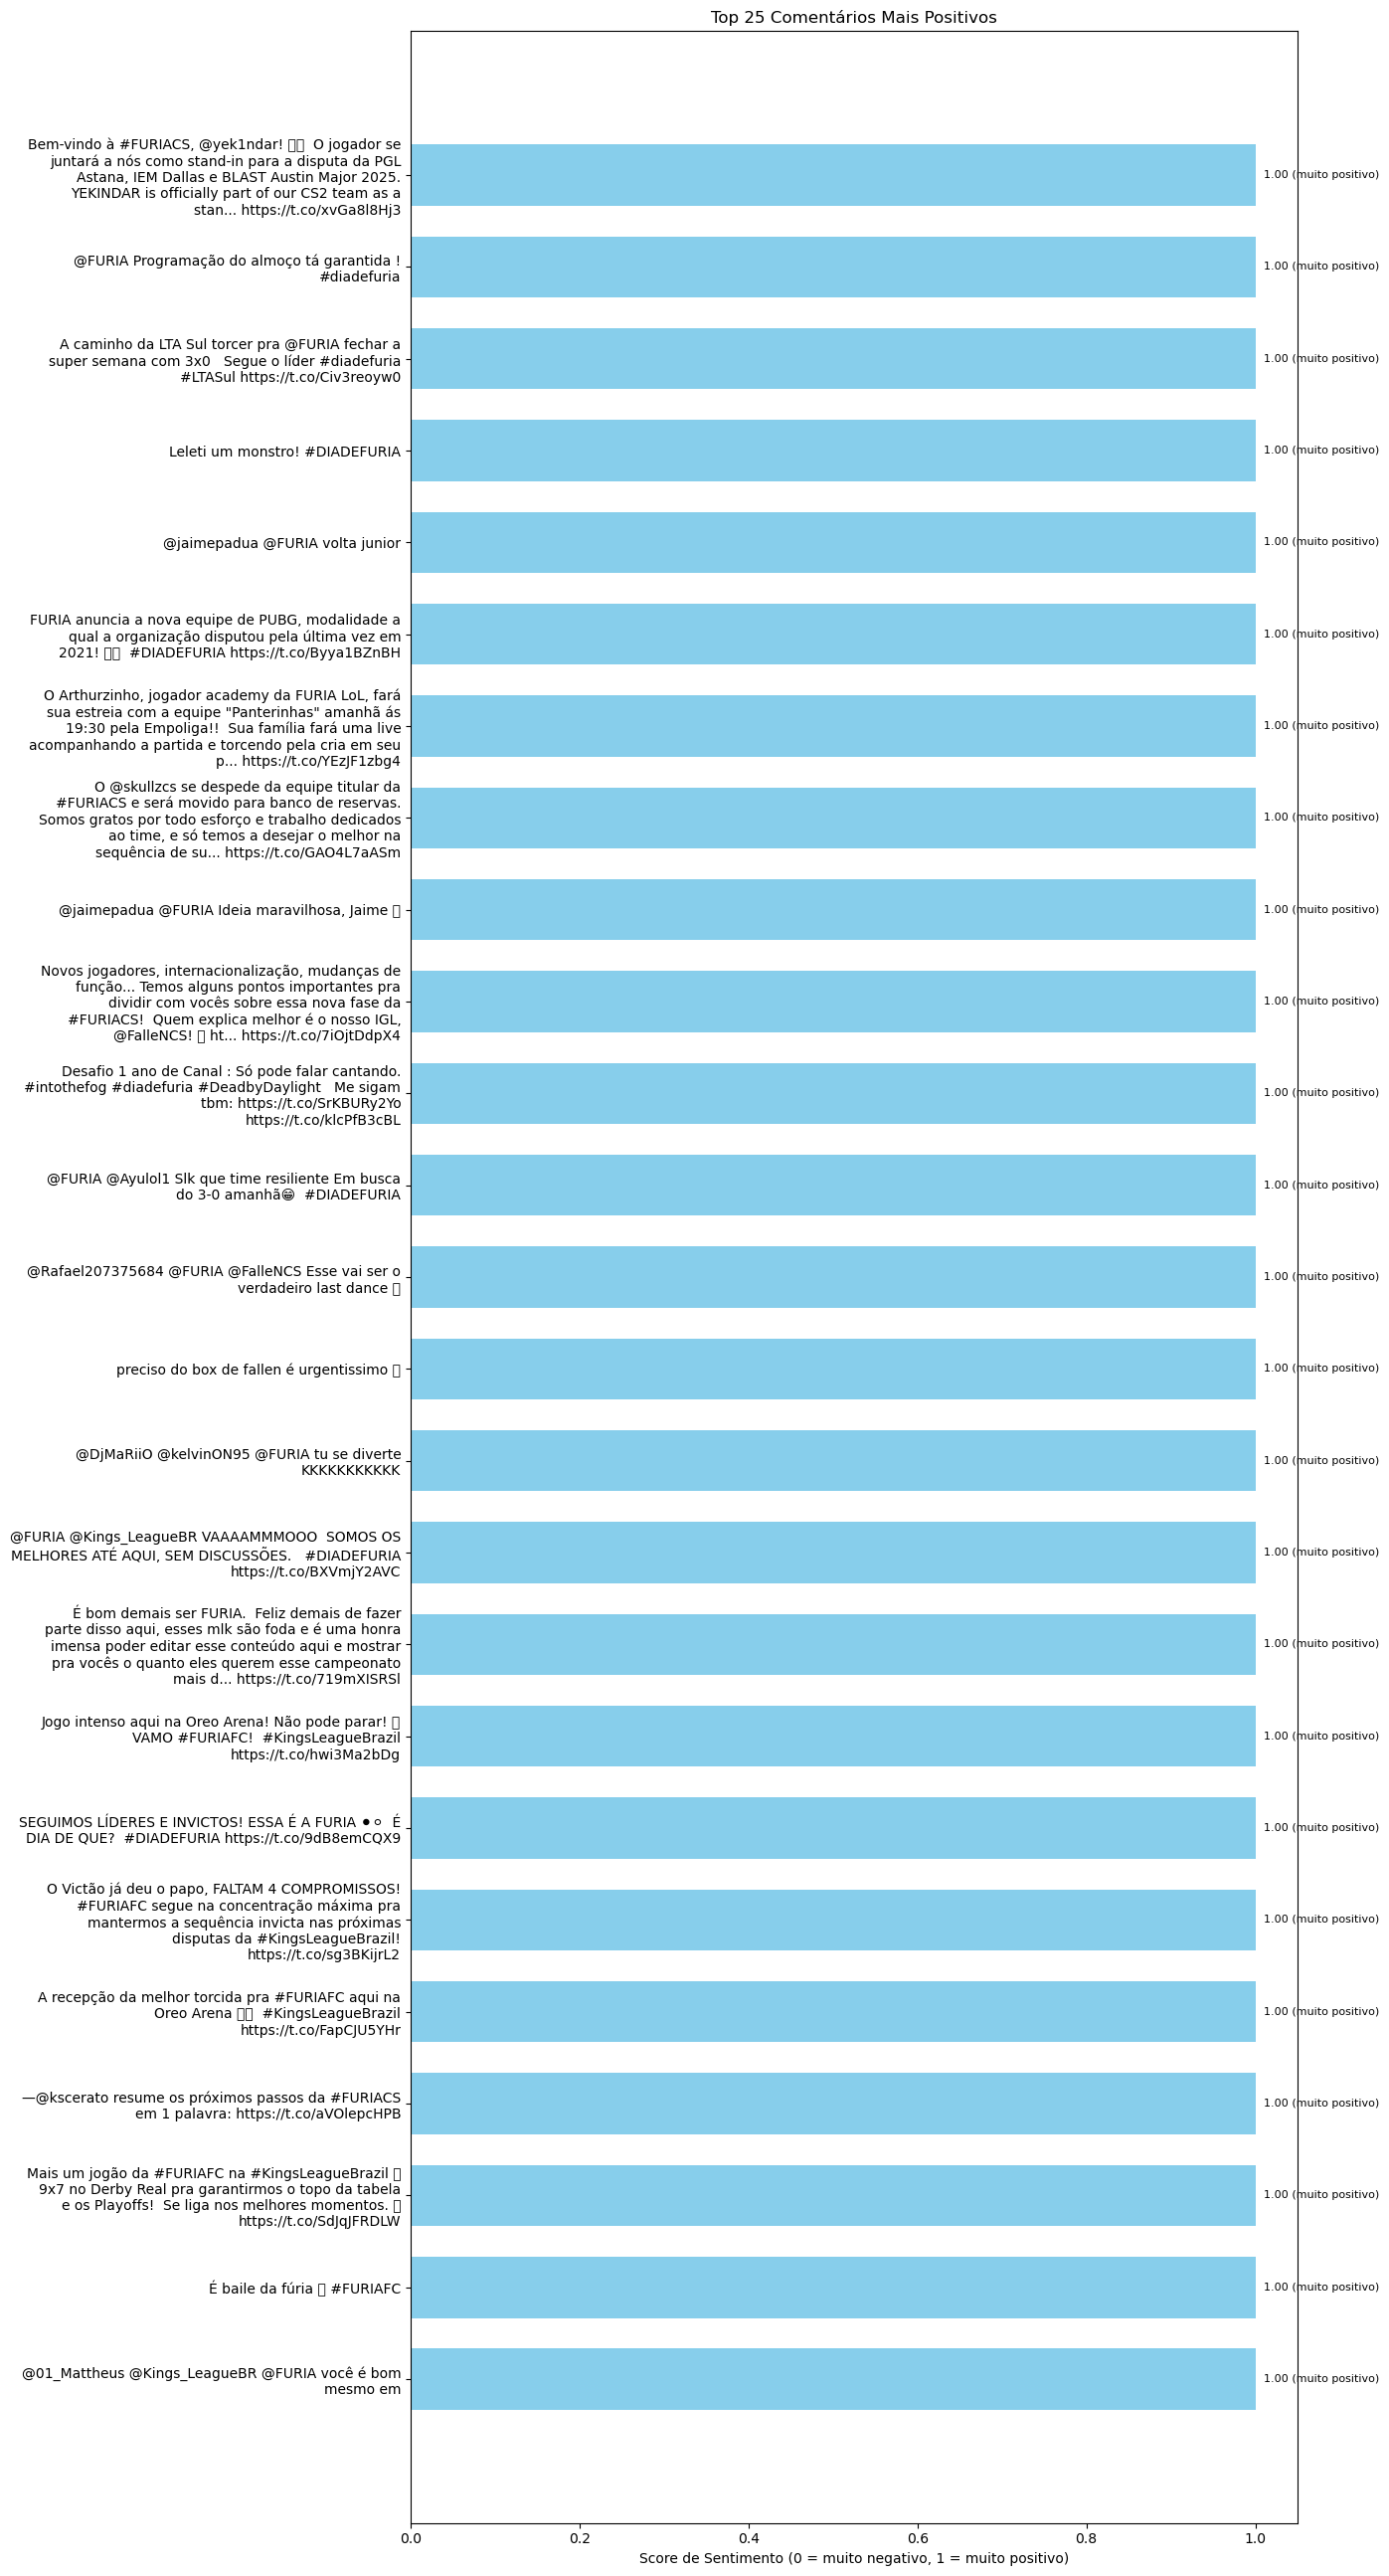

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
import textwrap
import json
import random

# ====== 1. Carrega os dados JSON ======
with open(R'form_data\tweets_furia.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# ====== 2. Remove duplicatas pelo texto e filtra pt ======
df = df.drop_duplicates(subset=['text'])
df = df[df['lang'] == 'pt'].copy()

# ====== 3. Simula likes ======
df['likes'] = [random.randint(1, 5000) for _ in range(len(df))]

# ====== 4. Seleciona os 200 mais curtidos ======
top200 = df.sort_values('likes', ascending=False).head(200).copy()

# ====== 5. Remove palavras banidas ======
palavras_banidas = ['CAPIM', 'Desempedidos', 'G3X', 'g3x', 
                    'DENDELE', 'LOUD', 'FUNKBOL', 'FLUXO REAL ELITE']
mask = ~top200['text'].str.upper().str.contains('|'.join(palavras_banidas))
top200_filtrado = top200[mask].reset_index(drop=True)

# ====== 6. Pipeline de sentimento ======
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    tokenizer="nlptown/bert-base-multilingual-uncased-sentiment"
)

# ====== 7. Aplica o modelo ======
batch_size = 32
texts = top200_filtrado['text'].tolist()
results = []
for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    results.extend(sentiment_analyzer(batch, truncation=True))

# ====== 8. Normaliza scores ======
scores = [(int(r['label'][0]) - 1) / 4 for r in results]
top200_filtrado['sentiment_score'] = scores

# ====== 9. Pega os TOP 25 mais positivos ======
top25 = top200_filtrado.sort_values('sentiment_score', ascending=False).head(25).copy()

# ====== 10. Funções auxiliares ======
def simplificar_comentario(texto, limite=200):
    if len(texto) <= limite:
        return texto
    palavras = texto.split()
    ultima_palavra = palavras[-1] if palavras else ''
    return f"{texto[:limite].rstrip()}... {ultima_palavra}"

def estrela_para_sentimento(score):
    stars = int(round(score * 4)) + 1
    return {
        1: "muito negativo",
        2: "negativo",
        3: "neutro",
        4: "positivo",
        5: "muito positivo"
    }[stars]

# ====== 11. Plot único com os TOP 25 ======
def plot_top25(df):
    comentarios = [
        textwrap.fill(simplificar_comentario(t), width=50)
        for t in df['text']
    ]
    scores = df['sentiment_score'].tolist()

    spacing = 1.2  # Espaço vertical entre comentários
    y_pos = [i * spacing for i in range(len(comentarios))][::-1]

    plt.figure(figsize=(14, len(df) * spacing * 0.8 + 2))
    plt.barh(y_pos, scores, color='skyblue')
    plt.yticks(y_pos, comentarios)
    plt.xlabel('Score de Sentimento (0 = muito negativo, 1 = muito positivo)')
    plt.title('Top 25 Comentários Mais Positivos')
    plt.gca().invert_yaxis()

    for y, s in zip(y_pos, scores):
        plt.text(s + 0.01, y, f'{s:.2f} ({estrela_para_sentimento(s)})',
                 va='center', fontsize=8)

    plt.tight_layout()
    plt.show()

# ====== 12. Executa o plot ======
plot_top25(top25)


##### Frequência de Tweets (Intervalo de 3h)

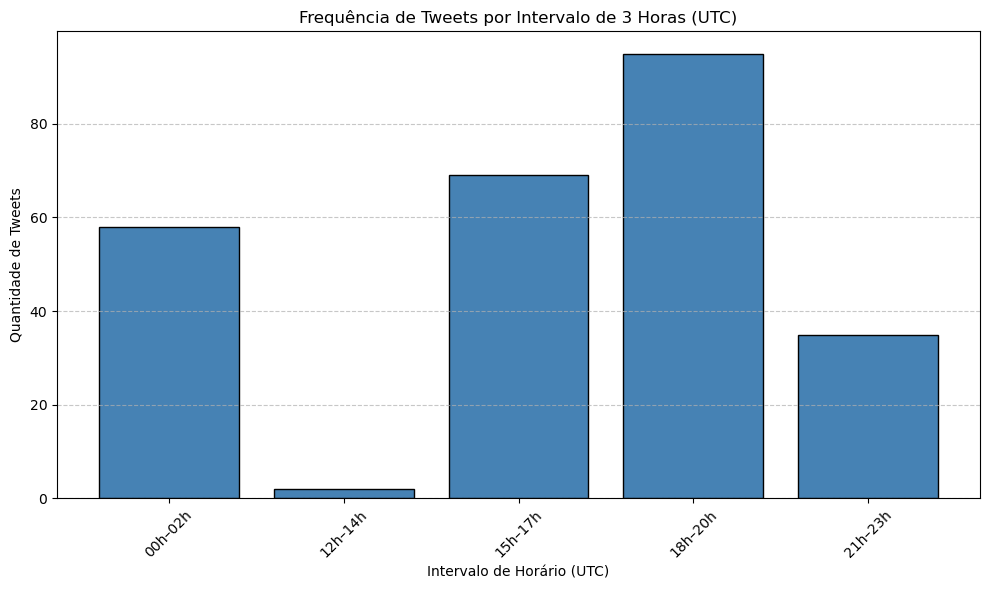

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime

# ====== 1. Carrega os dados ======
with open('form_data/tweets_furia.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# ====== 2. Converte 'created_at' para datetime e extrai hora ======
df['created_at'] = pd.to_datetime(df['created_at'])
df['hora_utc'] = df['created_at'].dt.hour

# ====== 3. Agrupa por blocos de 3 horas (0-2, 3-5, ..., 21-23) ======
df['bloco_3h'] = df['hora_utc'].apply(lambda h: f"{(h//3)*3:02d}h–{(h//3)*3+2:02d}h")

# ====== 4. Conta tweets por bloco ======
frequencia_blocos = df['bloco_3h'].value_counts().sort_index()

# ====== 5. Plota o gráfico ======
plt.figure(figsize=(10, 6))
plt.bar(frequencia_blocos.index, frequencia_blocos.values, color='steelblue', edgecolor='black')
plt.xlabel('Intervalo de Horário (UTC)')
plt.ylabel('Quantidade de Tweets')
plt.title('Frequência de Tweets por Intervalo de 3 Horas (UTC)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


##### Localização

C:\Users\leomo\AppData\Local\Temp\ipykernel_3104\2040502681.py:41: UserWarning: Glyph 128062 (\N{PAW PRINTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\leomo\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128062 (\N{PAW PRINTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


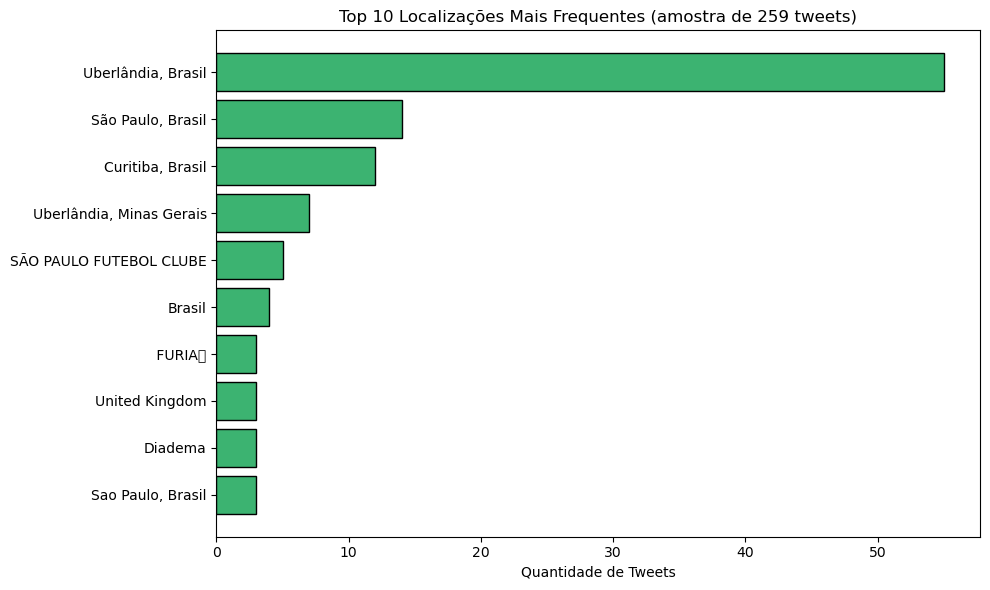

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# ====== Parâmetro de Amostragem ======
sample_size = 500  # defina aqui quantos tweets quer incluir na análise

# ====== 1. Carrega os dados JSON ======
with open('form_data/tweets_furia.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
df = pd.DataFrame(data)

# ====== 2. Reduz a amostragem ======
if len(df) > sample_size:
    df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)

# ====== 3. Extrai localização dos usuários ======
df['localizacao'] = df['user'].apply(
    lambda u: u.get('location') if isinstance(u, dict) else None
)

# ====== 4. Remove valores nulos ou vazios ======
df_local = df[
    df['localizacao'].notna() &
    (df['localizacao'].str.strip() != '')
].copy()

# ====== 5. Conta os locais mais frequentes ======
frequencia_locais = df_local['localizacao'].value_counts().head(10)

# ====== 6. Plota gráfico de barras ======
plt.figure(figsize=(10, 6))
plt.barh(
    frequencia_locais.index[::-1],
    frequencia_locais.values[::-1],
    color='mediumseagreen',
    edgecolor='black'
)
plt.xlabel('Quantidade de Tweets')
plt.title(f'Top 10 Localizações Mais Frequentes (amostra de {len(df)} tweets)')
plt.tight_layout()
plt.show()


##### Idade das Contas

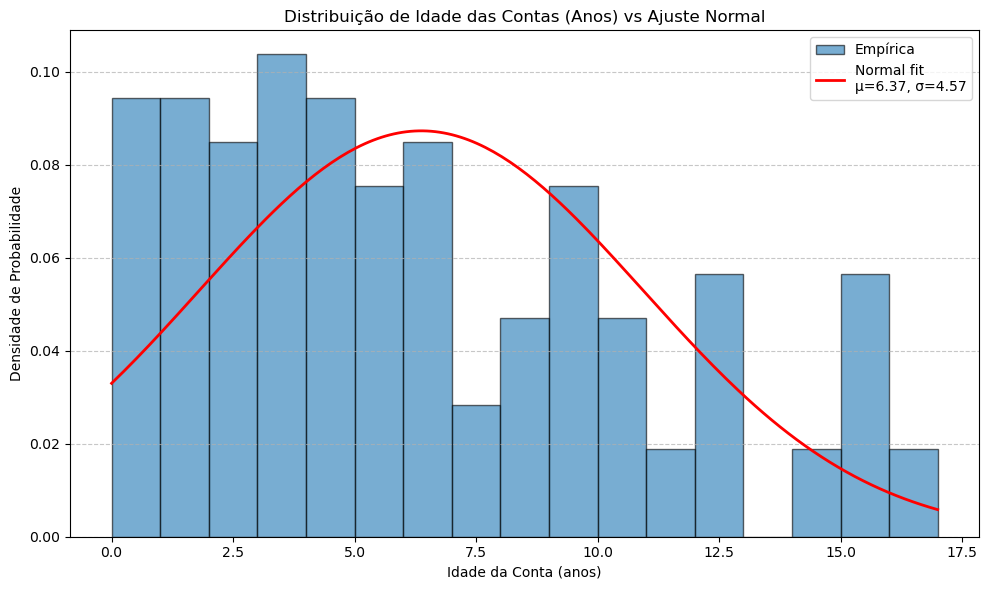

In [29]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ====== 1. Carrega os dados JSON ======
with open('form_data/tweets_furia.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
df = pd.DataFrame(data)

# ====== 2. Converte e calcula idade das contas ======
df['account_created_at'] = pd.to_datetime(
    df['user'].apply(lambda u: u.get('created_at') if isinstance(u, dict) else None),
    utc=True,
    errors='coerce'
)
df = df[df['account_created_at'].notna()]
hoje = pd.Timestamp('2025-05-01 00:00:00', tz='UTC')
df['age_years'] = (hoje - df['account_created_at']).dt.days / 365.25
unicos = df.drop_duplicates(subset=['author_id']).copy()

# ====== 3. Extrai as idades ======
ages = unicos['age_years']

# ====== 4. Plota histograma com densidade ======
plt.figure(figsize=(10,6))
# histogramas normalizados (área = 1)
counts, bins, patches = plt.hist(ages, bins=range(0, int(ages.max())+2), 
                                 density=True, alpha=0.6, edgecolor='black',
                                 label='Empírica')

# ====== 5. Ajusta distribuição normal ======
mean, std = ages.mean(), ages.std()
x = np.linspace(bins[0], bins[-1], 200)
normal_pdf = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std)**2)

plt.plot(x, normal_pdf, 'r-', linewidth=2, label=f'Normal fit\nμ={mean:.2f}, σ={std:.2f}')

# ====== 6. Formatação ======
plt.title('Distribuição de Idade das Contas (Anos) vs Ajuste Normal')
plt.xlabel('Idade da Conta (anos)')
plt.ylabel('Densidade de Probabilidade')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Visualização

#### Dashbord Geral

In [ ]:
#Código Referente a Análise Individual (não modificada)

import json
import os
import base64
from collections import Counter
import pandas as pd
import random
from transformers import pipeline
import dash
from dash import dcc, html
import plotly.express as px

# ====== 1. Configurações iniciais ======
DATA_DIR = 'form_data'

with open(os.path.join(DATA_DIR, 'last_user_id.json'), 'r', encoding='utf-8') as f:
    USER_ID = json.load(f)['last_user_id']
USER_JSON = os.path.join(DATA_DIR, f'{USER_ID}.json')
USER_IMAGE_PATH = os.path.join(DATA_DIR, f'{USER_ID}_selfie.png')
TWEETS_JSON = os.path.join(DATA_DIR, 'tweets_User.json')

# ====== 2. Carrega dados de usuário ======
with open(USER_JSON, 'r', encoding='utf-8') as f:
    user = json.load(f)

# ====== 2.1 Classificação de Produtos ======
COLLABS_KEYWORDS = ['Adidas', 'Batman', 'Champion', 'My Hero Academia', 'Zor', 'New Era']
COLECOES_KEYWORDS = ['Classic', 'Clutch', 'Furia', 'Future is Black', 'Hard To Love x Harder To Kill', 'Magic Panthera', 'Spray It']
produtos = user.get('produtos_furia', [])
collabs = [p for p in produtos if p in COLLABS_KEYWORDS]
colecoes = [p for p in produtos if p in COLECOES_KEYWORDS]
produtos_restantes = [p for p in produtos if p not in COLLABS_KEYWORDS + COLECOES_KEYWORDS]

# ====== 3. Carrega e processa tweets ======
df = pd.read_json(TWEETS_JSON)
df = df.drop_duplicates(subset=['text'])
gen = random.Random(42)
df['likes'] = [gen.randint(1, 5000) for _ in range(len(df))]
top = df.sort_values('likes', ascending=False).head(300)

# ====== 4. Análise de Sentimento ======
sentiment_analyzer = pipeline(
    'sentiment-analysis',
    model='nlptown/bert-base-multilingual-uncased-sentiment',
    tokenizer='nlptown/bert-base-multilingual-uncased-sentiment'
)
results = sentiment_analyzer(top['text'].tolist(), truncation=True)
top['sentiment_score'] = [(int(r['label'][0]) - 1) / 4 for r in results]

def score_to_star(score):
    return int(round(score * 4)) + 1

top['stars'] = top['sentiment_score'].apply(score_to_star)

# ====== 5. Estatísticas de Texto ======
STOPWORDS = set([
    'a', 'o', 'as', 'os', 'e', 'é', 'de', 'do', 'da', 'dos', 'das', 'em', 'no', 'na', 'nos', 'nas',
    'um', 'uma', 'uns', 'umas', 'para', 'por', 'com', 'sem', 'que', 'qui', 'on', 'the', 'and', 'is', 'in', 'to', 'of', 'it', 'you', 'for', 'this'
])
word_counts = Counter()
for text in top['text']:
    for w in text.lower().split():
        w_clean = ''.join(ch for ch in w if ch.isalpha())
        if w_clean and w_clean not in STOPWORDS:
            word_counts[w_clean] += 1

top_words = word_counts.most_common(10)

# ====== 6. Geração de Gráficos ======
fig_sentiment = px.bar(
    x=top['stars'].value_counts().sort_index().index.astype(str) + '★',
    y=top['stars'].value_counts().sort_index().values,
    title='Distribuição de Sentimento por Estrelas',
    labels={'x': 'Estrelas', 'y': 'Contagem'},
    template='plotly_dark'
)

fig_words = px.bar(
    x=[w for w, _ in top_words],
    y=[cnt for _, cnt in top_words],
    title='Top 10 Palavras Mais Usadas',
    labels={'x': 'Palavra', 'y': 'Frequência'},
    template='plotly_dark'
)

# ====== 7. Frase mais positiva e Fã % ======
best_idx = top['sentiment_score'].idxmax()
best_phrase = top.loc[best_idx, 'text']
fan_pct = top['sentiment_score'].mean() * 100

# ====== 7.1 Define emoji conforme nível de fã ======
if fan_pct > 75:
    fan_emoji = '🖤'  # Pantera
elif fan_pct > 60:
    fan_emoji = '😊'  # feliz
elif fan_pct > 45:
    fan_emoji = '😐'  # sem emoção
elif fan_pct > 25:
    fan_emoji = '☹️'  # triste
else:
    fan_emoji = '😭'  # chorando

# ====== 8. Encode da Imagem ======
encoded_image = base64.b64encode(open(USER_IMAGE_PATH, 'rb').read()).decode()
IMAGE_SRC = f'data:image/png;base64,{encoded_image}'

# ====== 9. Monta App Dash ======
app = dash.Dash(__name__)
app.layout = html.Div(
    style={
        'backgroundColor': '#121212',
        'color': '#e0e0e0',
        'fontFamily': 'Inter, sans-serif',
        'padding': '20px'
    },
    children=[
        html.H1(
            'Dashboard Geral: Fã da FURIA',
            style={'textAlign': 'center', 'color': '#fff', 'fontFamily': 'Georgia, serif'}
        ),
        html.Div(
            style={'display': 'flex', 'gap': '20px'},
            children=[
                html.Div(
                    style={
                        'flex': '2',
                        'backgroundColor': '#1e1e1e',
                        'padding': '20px',
                        'borderRadius': '10px',
                        'boxShadow': '0 4px 15px rgba(0,0,0,0.2)'
                    },
                    children=[
                        html.Img(
                            src=IMAGE_SRC,
                            style={'width': '120px', 'borderRadius': '8px', 'marginBottom': '15px', 'display': 'block', 'margin': '0 auto'}
                        ),
                        html.Blockquote(
                            best_phrase,
                            style={
                                'borderLeft': '4px solid #4caf50',
                                'padding': '10px 15px',
                                'backgroundColor': '#2a2a2a',
                                'fontStyle': 'italic',
                                'fontFamily': 'Inter, sans-serif'
                            }
                        ),
                       html.P([
                            'Nome: ',
                            html.Span(user['nome'], style={'color': '#4caf50' if user.get('name_match') else '#888'})
                        ]),
                        html.P([
                            'Face match: ',
                            html.Span(
                                'Validado' if user.get('name_match') else 'Não verificado',
                                style={'color': '#4caf50' if user.get('name_match') else '#888'}
                            )
                        ]),
                        html.P([
                            'Naturalidade: ',
                            html.Span(
                                user.get('naturalidade_extraida') or '(não verificado)',
                                style={'color': '#4caf50' if user.get('naturalidade_extraida') else '#888'}
                            )
                        ]),

                        html.P(f'Porcentagem de fã: {fan_pct:.1f}% {fan_emoji}')
                    ]
                ),
                html.Div(
                    style={'flex': '1', 'backgroundColor': '#1e1e1e', 'padding': '20px', 'borderRadius': '10px', 'boxShadow': '0 4px 15px rgba(0,0,0,0.2)'},
                    children=[
                        html.H3('Interesses e Atividades', style={'fontFamily': 'Georgia, serif'}),
                        html.P('Jogos Favoritos: ' + ', '.join(user.get('jogos_furia', []))),
                        html.P('Produtos Comprados: ' + ', '.join(produtos_restantes)),
                        html.P('Collabs: ' + (', '.join(collabs) if collabs else 'Nenhum')),
                        html.P('Coleções: ' + (', '.join(colecoes) if colecoes else 'Nenhuma')),
                        html.P('Eventos: ' + user.get('eventos_furia', ''))
                    ]
                )
            ]
        ),
        html.Div(
            style={'display': 'flex', 'gap': '20px', 'marginTop': '30px'},
            children=[
                html.Div(dcc.Graph(figure=fig_words), style={'flex': '1', 'backgroundColor': '#1e1e1e', 'padding': '10px', 'borderRadius': '8px'}),
                html.Div(dcc.Graph(figure=fig_sentiment), style={'flex': '1', 'backgroundColor': '#1e1e1e', 'padding': '10px', 'borderRadius': '8px'})
            ]
        )
    ]
)

if __name__ == '__main__':
    app.run()


KeyboardInterrupt: 

<div style="text-align: center;"> <h3>Estruturação do Notebook</h3> </div>

- Organizar o notebook em seções claras conforme as etapas acima: **Coleta de Dados**, **Validação de Identidade**, **Integração de Redes Sociais**, **Enriquecimento com Dados Sociais**, **Conclusão**.  
- Incluir explicações breves em cada seção usando células Markdown, resumindo o objetivo daquela etapa. Combinar descrições em texto com células de código demonstrativas.  
- Sugerir bibliotecas específicas no contexto de cada etapa: por exemplo, mencionar `ipywidgets` ou `streamlit` na coleta de dados, `pytesseract`/`OpenCV` na validação de documentos, `tweepy`/`PRAW`/`BeautifulSoup` na integração social, e `transformers`/`spaCy` na análise de linguagem.

<div style="text-align: center;"> <h3>Dicas de Apresentação do Protótipo</h3> </div>

- **Formatação Atraente:** Usar cabeçalhos (`#`, `##`), listas e imagens (logotipos de e-sports, ícones de redes sociais) para tornar o notebook visualmente agradável. Células Markdown bem elaboradas ajudam na legibilidade.  
- **Interatividade:** Incluir elementos interativos (sliders, botões de upload, caixas de seleção) via `ipywidgets` para simular um fluxo real de uso. Isso torna a demonstração dinâmica mesmo no ambiente de notebook.  
- **Visualização de Dados:** Aproveitar gráficos (matplotlib, seaborn ou plotly) para mostrar perfis de interesse ou resultados das análises de comentários. Um gráfico de barras ou nuvem de palavras torna o conteúdo mais didático.  
- **Narração do Código:** Inserir comentários explicativos e outputs de exemplo que guiem o avaliador pelo processo passo a passo. Ao final, apresentar um breve resumo dos resultados obtidos para evidenciar que todos os requisitos foram atendidos.  

<div style="text-align: center;"> <h3>Conclusão</h3> </div>

Este plano garante uma implementação completa dos requisitos do desafio, integrando coleta de informações pessoais e de interesse em e-sports, validação de identidade baseada em IA, simulação de integração social e enriquecimento de perfil com dados externos. A organização em seções claras, o uso de bibliotecas especializadas (ex: **Streamlit/ipywidgets** para interfaces, **OpenCV/face_recognition** para validação, **transformers/spaCy** para IA, **pandas** para dados) e as sugestões de apresentação asseguram uma entrega alinhada e de fácil acompanhamento, mesmo no formato de notebook.